In [17]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60

df = df / 1000
df

,АЗС №35400 Кичменгский Городок,АЗС №35401 Великий Устюг-1,АЗС №35402 Великий Устюг-2,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35406 Журавлево,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,99.2272,101.8513,139.2135,154.2522,777.2635,102.4328,520.5020,517.8863,266.7014,...,610.3886,610.3028,607.3283,609.0579,611.0852,611.0605,604.2684,605.7555,502.9826,477.9325
1,99.0684,0.0000,4.9465,134.5201,149.5589,748.0318,5.5280,491.2703,488.6546,241.7276,...,581.1570,581.0711,578.0967,579.8263,581.8535,581.8288,575.0368,576.5238,473.7510,448.7008
2,101.8148,5.0688,0.0000,137.2665,152.3053,750.7781,3.0302,494.0166,491.4010,244.4739,...,583.9033,583.8174,580.8430,582.5726,584.5999,584.5752,577.7831,579.2702,476.4973,451.4472
3,139.2135,134.6791,137.3031,0.0000,15.0961,613.5690,137.8846,356.8075,354.1918,107.2648,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
4,154.2522,149.7178,152.3419,15.0961,0.0000,613.8947,152.9234,357.1332,354.5176,107.5905,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,611.7861,582.6174,585.2414,447.9957,448.3214,191.2351,585.8229,181.8523,179.2367,345.2112,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
60,605.7962,576.6275,579.2515,442.0057,442.3315,185.0682,579.8330,175.8624,173.2467,339.2213,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
61,607.1467,577.9779,580.6020,443.3562,443.6820,186.4186,581.1835,177.2129,174.5972,340.5717,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
62,504.6641,475.4954,478.1194,340.8736,341.1994,274.3706,478.7009,74.7303,72.1146,238.0892,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [18]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35412 Вытегра,АЗС №35413 Липник,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,613.5690,356.8075,354.1918,107.2648,619.0077,618.5201,629.3182,472.6696,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,613.8947,357.1332,354.5176,107.5905,619.3335,618.8458,629.6440,472.9954,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
2,615.1980,615.5238,0.0000,349.0547,346.4390,512.4135,142.9597,142.4720,165.8965,193.2966,...,187.4480,187.3622,184.7850,188.3816,183.6881,191.1772,185.1426,186.6296,274.4141,309.3918
3,356.1259,356.4516,349.7479,0.0000,3.7018,253.3414,355.1867,354.6990,373.5276,216.8790,...,182.8731,182.7873,179.8128,181.5424,183.5697,183.5450,176.7529,178.2400,75.4671,45.6714
4,353.5507,353.8764,347.1727,3.7422,0.0000,250.7662,352.6115,352.1238,370.9524,214.3038,...,180.2979,180.2120,177.2376,178.9672,180.9945,180.9698,174.1777,175.6648,72.8919,43.0962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,447.9957,448.3214,191.2351,181.8523,179.2367,345.2112,196.6738,196.1861,332.9386,176.2900,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,442.0057,442.3315,185.0682,175.8624,173.2467,339.2213,190.5069,190.0192,326.9487,170.3001,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,443.3562,443.6820,186.4186,177.2129,174.5972,340.5717,191.8574,191.3697,328.2991,171.6506,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,340.8736,341.1994,274.3706,74.7303,72.1146,238.0892,279.8093,279.3216,346.5072,189.8586,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [19]:
idx = [4,
 23,
 42,
 2,
 51,
 52,
 13,
 54,
 32,
 10,
 18,
 31,
 11,
 7,
 36,
 17,
 15,
 43,
 12,
 6,
 49,
 46,
 34,
 9,
 39,
 45,
 53,
 8,
 30,
 24,
 25,
 19,
 5,
 14,
 22,
 50,
 35,
 40,
 29,
 44,
 28,
 3,
 0,
 47,
 38]

In [20]:
from numpy.random import default_rng

#shrink array
#df = df.iloc[40:56,40:56]
rng = default_rng()
#idx = rng.choice(len(df.values[0])-1, size=len(df.values[0]) - 1 - 10, replace=False)
#print(idx)
df = df.drop(df.index[idx])
df = df.drop(df.columns[idx], axis=1)
df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

11


,АЗС №35404 Нюксеница,АЗС №35420 Шексна,АЗС №35427 Марьинское,АЗС №35429 Чекшино-1,АЗС №35434 Верховажье,АЗС №35435 Устюжна,АЗС №35441 Преображенского,АЗС №35445 Чернышевского-1,АЗС №35449 Нелазское,АЗС №35456 Маяковская,Нефтебаза
0,0.0000,391.4372,308.8242,244.9984,158.4343,551.6265,315.2839,305.8532,448.4384,443.9596,314.5638
1,392.4223,0.0000,82.8181,147.5906,304.4975,162.4712,77.6788,86.4086,59.2831,54.8043,86.2904
2,309.7320,82.6843,0.0000,64.9002,221.8072,242.8735,10.9076,8.0424,139.6855,135.2067,15.8192
3,244.8612,146.6791,64.0661,0.0000,156.9364,306.8684,70.5258,61.0950,203.6803,199.2015,69.8057
4,158.2224,303.4982,220.8852,157.0594,0.0000,463.6875,227.3449,217.9142,360.4994,356.0206,226.6248
5,553.2976,160.8752,243.6933,308.4658,465.3728,0.0000,238.5540,247.2839,103.5422,122.5588,247.1656
6,314.9784,78.0459,9.1574,70.1467,227.0536,238.2352,0.0000,9.1884,135.0471,130.5683,9.0701
7,306.0214,87.3570,8.1652,61.1897,218.0966,247.5463,9.4640,0.0000,144.3582,139.8794,8.7439
8,449.9896,57.5673,140.3854,205.1579,362.0648,103.6256,135.2461,143.9759,0.0000,18.9999,143.8577
9,445.0346,52.6123,135.4304,200.2029,357.1098,122.5360,130.2910,139.0209,19.3480,0.0000,138.9026


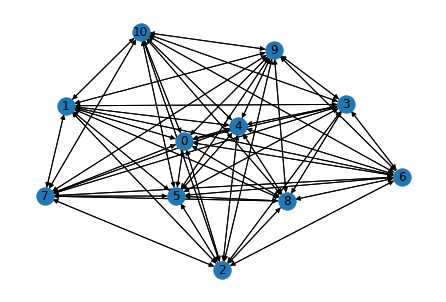

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G, with_labels = True)
plt.show()

In [22]:
#custom gym environment for our problem
m = 5
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [23]:
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 8
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config["env_config"] = {}
config["clip_param"] = 0.3
config["entropy_coeff"] = 0.01
config['lr'] = 0.0001
config["horizon"] = N #numbers of t_steps after which termiate
config["train_batch_size"] = 4000 
config["rollout_fragment_length"] = 500 # batch_size per worker

In [24]:
ray.shutdown()
ray.init()

2022-06-06 22:29:07,258	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8266


RayContext(dashboard_url='127.0.0.1:8266', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.76', 'raylet_ip_address': '192.168.1.76', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-06_22-29-05_270935_885418/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-06_22-29-05_270935_885418/sockets/raylet', 'webui_url': '127.0.0.1:8266', 'session_dir': '/tmp/ray/session_2022-06-06_22-29-05_270935_885418', 'metrics_export_port': 61008, 'gcs_address': '192.168.1.76:59710', 'address': '192.168.1.76:59710', 'node_id': '1eb64b5b9a394435360f9040e9af871265be8618d8b8a92469c50bf8'})

In [25]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [26]:
import datetime
start = datetime.datetime.now()
print(start)

for i in range(101):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
print("Total Hours: ", duration.total_seconds() / 3600)

2022-06-06 22:29:15.072887
i:  0
mean episode length: 11.0
max episode reward: -21462.5174
mean episode reward: -35794.869492777776
min episode reward: -54528.5184
total episodes: 360
i:  10
mean episode length: 11.0
max episode reward: -17143.8009
mean episode reward: -28813.265619836955
min episode reward: -46754.149699999994
total episodes: 4000
i:  20
mean episode length: 10.901639344262295
max episode reward: -7163.3598999999995
mean episode reward: -20809.145115573774
min episode reward: -46769.5163
total episodes: 7646
i:  30
mean episode length: 10.373056994818652
max episode reward: -7044.6481
mean episode reward: -13838.172739637306
min episode reward: -29283.9034
total episodes: 11407
i:  40
mean episode length: 10.173027989821882
max episode reward: -6948.6552999999985
mean episode reward: -11803.129668447838
min episode reward: -33020.097200000004
total episodes: 15307
i:  50
mean episode length: 10.103535353535353
max episode reward: -6828.1797
mean episode reward: -10767

In [27]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

action: [4 4]; reward: 0
action: [0 8]; reward: -2226.6063
action: [0 6]; reward: -2144.2879
action: [2 2]; reward: -135.2461
action: [2 7]; reward: -2015.2638
action: [2 3]; reward: -8.042399999999999
action: [2 0]; reward: -61.189699999999995
action: [0 1]; reward: -244.86120000000003
action: [0 9]; reward: -78.04589999999999
action: [1 5]; reward: -54.804300000000005
Final state:
Assignment: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Trucks used: [1. 1. 1. 0. 1.]
Time left [ 6  8  7 12  8]
-9215.8236


In [28]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

Truck #4: [4]
Truck #0: [8, 6, 1, 9]
Truck #2: [2, 7, 3, 0]
Truck #1: [5]


In [29]:
def GetLength(route):
    length = df.values[-1, route[0]]
    for i in range(1, len(route)):
        length += df.values[route[i-1], route[i]]
    length += df.values[route[-1], -1]
    
    return length

In [30]:
dist = 0
for k in truck_paths:
    dist += GetLength(truck_paths[k])
dist

2143.0804

In [31]:
for k in truck_paths:
    print(GetLength(truck_paths[k]) / truck_speed)

7.553851666666666
9.188113333333332
10.732015
8.244026666666667
